In [108]:
import numpy as np
import ast, dataIO, common_functions
from sklearn import cross_validation, linear_model, preprocessing
import GPy
reload(dataIO)
reload(common_functions)

postures = {"left_hand":["4", "8", "11"], "right_hand":["1", "7", "10"], 
            "index_finger":["3", "5", "12"], "two_hand":["2", "6", "9"]}

locations = []
bod = []
targets_x = []
targets_y = []
y = []
touch_centers = []

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr

def process_twohand(userid):
    
    centers = dataIO.get_key_centers()
    filenos = ["2", "6", "9"]
    
    for fileno in filenos:
        filename = "/home/dimitar/Desktop/Python/experiment/results/"+str(userid)+"_"+fileno+"up.txt"
        with open(filename, "r") as f:
            lines = f.read().splitlines()
            lines = map(lambda x: x.split('\t'), lines[1:])
            for line in lines:
                letter = line[1]
                location = list(ast.literal_eval(line[3]))
                center = centers[letter]
                
                if not dataIO.iscorrect(location, center):
                    continue
                
                if line[0] == "left":
                    y.append(0)
                else:
                    y.append(1)
                
                touch_centers.append(center)
                targets_x.append(center[0]-location[0])
                targets_y.append(center[1]-location[1])                
                locations.append(location)
                bod.append(dataIO.createlist(line[-1]))
    
                
process_twohand(12)

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

print("MSE on x before regression: %.2f"  % np.mean(targets_x ** 2))
print("MSE on y before regression: %.2f"  % np.mean(targets_y ** 2))
within_before = common_functions.circle_button_error(locations, touch_centers)

foldno = 1
se_x = []
se_y = []
within_after = []
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)

for train_index, test_index in kf:    
    points_train, points_test = locations[train_index], locations[test_index]
    bod_train, bod_test = bod[train_index], bod[test_index]
    t_x_train, t_x_test = targets_x[train_index], targets_x[test_index]
    t_y_train, t_y_test = targets_y[train_index], targets_y[test_index]
    y_train, y_test = y[train_index], y[test_index]
    centers_train, centers_test = touch_centers[train_index], touch_centers[test_index]
    
    scaler = preprocessing.StandardScaler().fit(bod_train)  
    bod_scaled = scaler.transform(bod_train)
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1 ,1e-2, 1e-3, 1e-4],
                         'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]}]
    
    y_train = y_train.reshape(y_train.size, 1)
    m = GPy.models.GPClassification(bod_scaled, y_train)
    
    for i in range(5):
        m.optimize('bfgs', max_iters=100)
    
    regr_x = []
    regr_y = []
    
    for i in range(0,2):
        index = np.where(y_train==i)[0]
        regr_x.append(learn_offset(points_train[index], t_x_train[index]))
        regr_y.append(learn_offset(points_train[index], t_y_train[index]))
        
    new_points = []
    for i in range(len(points_test)):
        
        point = points_test[i]
        bod_data = scaler.transform(bod_test[i])
        bod_data = bod_data.reshape(1, 24)
        pred = m.predict(bod_data)
        
        if pred[0][0][0]>0.5:
            pred = 1
        else:
            pred = 0
            
        pred_x = regr_x[pred].predict(point)
        pred_y = regr_y[pred].predict(point)
        
        new_points.append([point[0]+pred_x, point[1]+pred_y])
     
    within_after.append(common_functions.circle_button_error(new_points, centers_test))
    new_points = np.array(new_points).T
    centers_test = centers_test.T
    
    se_x.append((new_points[0]-centers_test[0])**2)
    se_y.append((new_points[1]-centers_test[1])**2)
    
    foldno +=1    

se_x = np.array([item for sublist in se_x for item in sublist])
se_y = np.array([item for sublist in se_y for item in sublist])

print 
print("Mean MSE on x: %.2f" % np.mean(se_x))
print("Mean MSE on y: %.2f" % np.mean(se_y))      
within_after = np.mean(np.array(within_after), 0)
    

MSE on x before regression: 316.26
MSE on y before regression: 94.00

Mean MSE on x: 94.95
Mean MSE on y: 86.64


In [100]:
a = np.array([1,2,3])
print a
a = a.reshape(1, 3)
print a

[1 2 3]
[[1 2 3]]


Optimization restart 1/10, f = -18.4083494916
Optimization restart 2/10, f = -18.4083494916
Optimization restart 3/10, f = -18.4083494908
Optimization restart 4/10, f = -18.4083494916
Optimization restart 5/10, f = -18.4083494916
Optimization restart 6/10, f = -18.4083494916
Optimization restart 7/10, f = -18.4083494916
Optimization restart 8/10, f = -18.4083494916
Optimization restart 9/10, f = -18.4083494915
Optimization restart 10/10, f = -18.4083494916


{'dataplot': [<matplotlib.lines.Line2D at 0x7f9648487450>],
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f9648472050>],
  [<matplotlib.lines.Line2D at 0x7f9648472dd0>]]}

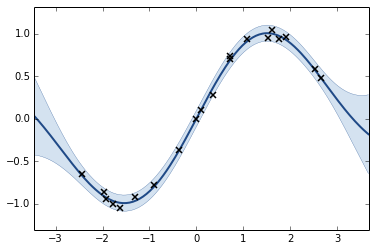

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)
m.optimize_restarts(num_restarts=10) # m.optimize(messages=True)

m.plot()

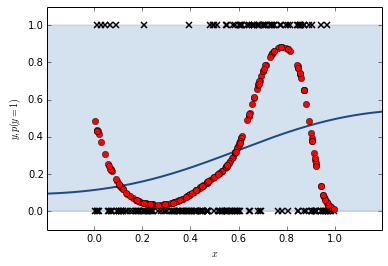

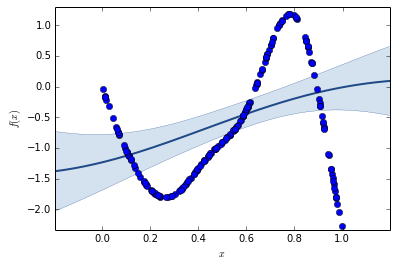

In [84]:
k = GPy.kern.RBF(1, variance=7., lengthscale=0.2)
X = np.random.rand(200,1)

f = np.random.multivariate_normal(np.zeros(200), k.K(X))
lik = GPy.likelihoods.Bernoulli()
p = lik.gp_link.transf(f)

Y = lik.samples(f).reshape(-1,1)

# m = GPy.core.GP(X=X,
#                 Y=Y, 
#                 kernel=k, 
#                 inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
#                 likelihood=lik)

m = GPy.models.GPClassification(X,Y)

m.plot()
plt.plot(X, p, 'ro')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')

m.plot_f()
plt.plot(X, f, 'bo')
plt.ylabel('$f(x)$');plt.xlabel('$x$')


Name                 : gp_classification
Log-likelihood       : -336.016997319
Number of Parameters : 2
Parameters:
  gp_classification.  |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance        |    1.0  |     +ve      |         |         
  rbf.lengthscale     |    1.0  |     +ve      |         |          

iteration: 0 
Name                 : gp_classification
Log-likelihood       : -316.717204223
Number of Parameters : 2
Parameters:
  gp_classification.  |      Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance        |    1.2306320484  |     +ve      |         |         
  rbf.lengthscale     |  0.185930672874  |     +ve      |         |         

iteration: 1 
Name                 : gp_classification
Log-likelihood       : -354.071252927
Number of Parameters : 2
Parameters:
  gp_classification.  |      Value       |  Constraint  |  Prior  |  Tied to
  rbf.variance        |   1.82206831563  |     +ve      |         |         
  rbf.lengthscale     |  0.1908

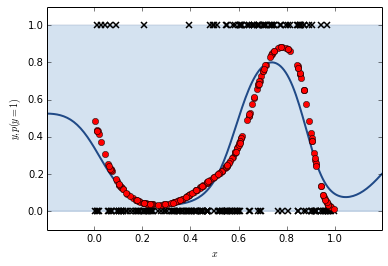

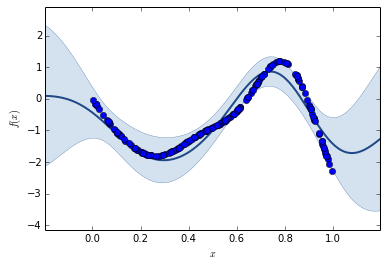

In [85]:
print m, '\n'
for i in range(5):
    m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters
    print 'iteration:', i,
    print m
    print ""
        
m.plot()
plt.plot(X, p, 'ro')
plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')

m.plot_f()
plt.plot(X, f, 'bo')
plt.ylabel('$f(x)$');plt.xlabel('$x$')